# ASD Meta-Analysis

#### This notebook contains the steps to process that allow you to obtain a dataframe of the log2fold chagnes for all features shared across the 13 dataseta, for any taxonomic level.

In [1]:
#Import dependencies
import os
import qiime2 as q2
import pandas as pd
import seaborn as sns
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
from collections import Counter
from qiime2 import Visualization
from qiime2 import Metadata
from qiime2.plugins import feature_table
from qiime2 import Artifact
from functools import reduce
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pandas import read_csv, Series, DataFrame

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Define functions

In [89]:
def taxa_process(study, level, feature):
  
    if study == 'amgut':
        meta_file = amgut
        path = "../../Amgut/2-20"
    if study == 'amgut_bloom_filt':
        meta_file = amgut_bloom_filt
        path = "../../Amgut/Bloom_filt_data"
    if study == 'berding':
        meta_file = berding_stat
        path = "../../Berding_2020"
    if study == 'cao':
        meta_file = cao_stat
        path = "../../Cao_2021"
    if study == 'chen':
        meta_file = chen_stat
        path = "../../Chen_2020"
    if study == 'dan':
        meta_file = dan_stat
        path = "../../Dan_2020"
    if study == 'david':
        meta_file = david_stat
        path = "../../David_2021"
    if study == 'huang':
        meta_file = huang_stat
        path = "../../Huang_2021"
    if study == 'fouquier':
        meta_file = fouquier_stat
        path = "../../Fouquier_2021"
    if study == 'kang':
        meta_file = kang_stat
        path = "../../Kang_2017"
    if study == 'kong':
        meta_file = kong_stat
        path = "../../Kong_2019"
    if study == 'liu':
        meta_file = liu_stat
        path = "../../Liu_2019"
    if study == 'son':
        meta_file = son_stat
        path = "../../Son_2015"
    if study == 'zou':
        meta_file = zou_stat
        path = "../../Zou_2020"
    if study == 'zurita':
        meta_file = zurita_stat
        path = "../../Zurita_2019"
        
    df = pd.read_csv("./%s/%s_table_ASDvControl_pvalues.csv" % (path,level),index_col=0)
    df.index.name = '%s' % level
    df.reset_index(inplace=True)
    df = df.drop(df.loc[df['%s' % level]!="%s" % feature].index)
    df = df.drop(['ASD Mean', 'Control Mean', 'Fold Change(ASD/Control)', '-Log(P-value)', 'Overall_Mean', 'ASD/Control pi score', 'Relevance_Score', 'ttest_pvalue', 'Log2(Fold Change)'], axis=1)
    df = df.set_index('%s' % level).T.rename_axis('#SampleID').reset_index()
    df_2 = df.set_index('#SampleID') 

    df_3 = pd.merge(meta_file, df_2, on='#SampleID', sort=False)

    return(df_3)


In [90]:
def ttest(df,ttdf1,ttdf2):
    from scipy.stats import ttest_ind
    ttests=[]
    ttdf1 = ttdf1.transpose()
    ttdf2 = ttdf2.transpose()
    ttests = ttest_ind(ttdf1,ttdf2,equal_var=False,nan_policy='omit')
    ttests = ttests.pvalue.transpose()
    df['ttest_pvalue']=ttests
    
def fold(df, sub1, sub2, sub1name, sub2name):
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Overall_Mean'] = (df['%s Mean' % (sub1name)]+df['%s Mean' % (sub2name)])/2
    df['Fold Change(%s/%s)' % (sub1name,sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    print("Fold Change Column Name = 'Fold Change(%s/%s)'" %(sub1name,sub2name))
    
def piscore(df,sub1name,sub2name):
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']
    df['Relevance_Score'] = 1/(-np.log10(abs(df['%s/%s pi score'% (sub1name,sub2name)])*df['Overall_Mean']))

def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)

In [91]:
def control_type_add(row): 
    if row['Study'] == "American Gut" or row['Study'] == "amgut_bloom_filt" :
        return "No Relationship"
    if row['Study'] == "Berding2020" or row['Study'] == "berding" :
        return "No Relationship"
    if row['Study'] == "Cao2021" or row['Study'] == "cao" :
        return "No Relationship"
    if row['Study'] == "Chen2020" or row['Study'] == "chen" :
        return "No Relationship"
    if row['Study'] == "Dan2020" or row['Study'] == "dan" :
        return "No Relationship"
    if row['Study'] == "David2021" or row['Study'] == "david" :
        return "Related"
    if row['Study'] == "Huang2021" or row['Study'] == "huang" :
        return "No Relationship"
    if row['Study'] == "Fouquier2021" or row['Study'] == "fouquier" :
        return "Related"
    if row['Study'] == "Kang2017" or row['Study'] == "kang" :
        return "No Relationship"
    if row['Study'] == "Kong2019" or row['Study'] == "kong" : 
        return "Related"
    if row['Study'] == "Liu2019" or row['Study'] == "liu" :
        return "No Relationship"
    if row['Study'] == "Son2015" or row['Study'] == "son" :
        return "Related"
    if row['Study'] == "Zou2020" or row['Study'] == "zou" :
        return "No Relationship"
    if row['Study'] == "Zurita2019" or row['Study'] == "zurita" :
        return "No Relationship"
    else :
        return 'NaN'
    
def sequencing_depth_range(row): 
    if row['Study'] == "American Gut" or row['Study'] == "amgut_bloom_filt" :
        return "< 6000"
    if row['Study'] == "Berding2020" or row['Study'] == "berding" :
        return "< 6000"
    if row['Study'] == "Cao2021" or row['Study'] == "cao" :
        return "< 6000"
    if row['Study'] == "Chen2020" or row['Study'] == "chen" :
        return "> 1400"
    if row['Study'] == "Dan2020" or row['Study'] == "dan" :
        return "> 1400"
    if row['Study'] == "David2021" or row['Study'] == "david" :
        return "< 6000"
    if row['Study'] == "Huang2021" or row['Study'] == "huang" :
        return "> 1400"
    if row['Study'] == "Fouquier2021" or row['Study'] == "fouquier" :
        return "> 1400"
    if row['Study'] == "Kang2017" or row['Study'] == "kang" :
        return "< 6000"
    if row['Study'] == "Kong2019" or row['Study'] == "kong" :
        return "> 1400"
    if row['Study'] == "Liu2019" or row['Study'] == "liu" :
        return "> 1400"
    if row['Study'] == "Son2015" or row['Study'] == "son" :
        return "> 1400"
    if row['Study'] == "Zou2020" or row['Study'] == "zou" :
        return "> 1400"
    if row['Study'] == "Zurita2019" or row['Study'] == "zurita" :
        return "< 6000"
    else :
        return 'NaN'

def country(row): 
    if row['Study'] == "American Gut" or row['Study'] == "amgut_bloom_filt" :
        return "USA"
    if row['Study'] == "Berding2020" or row['Study'] == "berding" :
        return "USA"
    if row['Study'] == "Cao2021" or row['Study'] == "cao" :
        return "China"
    if row['Study'] == "Chen2020" or row['Study'] == "chen" :
        return "China"
    if row['Study'] == "Dan2020" or row['Study'] == "dan" :
        return "China"
    if row['Study'] == "David2021" or row['Study'] == "david" :
        return "USA"
    if row['Study'] == "Huang2021" or row['Study'] == "huang" :
        return "China"
    if row['Study'] == "Fouquier2021" or row['Study'] == "fouquier" :
        return "USA"
    if row['Study'] == "Kang2017" or row['Study'] == "kang" :
        return "USA"
    if row['Study'] == "Kong2019" or row['Study'] == "kong" :
        return "USA"
    if row['Study'] == "Liu2019" or row['Study'] == "liu" :
        return "China"
    if row['Study'] == "Son2015" or row['Study'] == "son" :
        return "USA"
    if row['Study'] == "Zou2020" or row['Study'] == "zou" :
        return "China"
    if row['Study'] == "Zurita2019" or row['Study'] == "zurita" :
        return "Equador"
    else :
        return 'NaN'
    
def add_age(row): 
    if row['Age'] < 5 :
        return 'Below 5 years'
    if row['Age'] >= 5 and row['Age'] <= 7:
        return '5-7 years'
    if row['Age'] > 7:
        return 'Above 7 years'
    if row['Age'] == "Unknown":
        return "NaN"
    if row['Age'] == "NaN":
        return "NaN"
    else :
        return 'NaN'
    
def vr(row): 
    if row['Study'] == "American Gut" or row['Study'] == "amgut_bloom_filt":
        return "V4"
    if row['Study'] == "Berding2020" or row['Study'] == "berding" :
        return "V3V4"
    if row['Study'] == "Cao2021" or row['Study'] == "cao" :
        return "V4"
    if row['Study'] == "Chen2020" or row['Study'] == "chen" :
        return "V3V4"
    if row['Study'] == "Dan2020" or row['Study'] == "dan" :
        return "V4"
    if row['Study'] == "David2021" or row['Study'] == "david" :
        return "V4"
    if row['Study'] == "Huang2021" or row['Study'] == "huang" :
        return "V4"
    if row['Study'] == "Fouquier2021" or row['Study'] == "fouquier" :
        return "V4"
    if row['Study'] == "Kang2017" or row['Study'] == "kang" :
        return "V4"
    if row['Study'] == "Kong2019" or row['Study'] == "kong" :
        return "V3V4"
    if row['Study'] == "Liu2019" or row['Study'] == "liu" :
        return "V3V4"
    if row['Study'] == "Son2015" or row['Study'] == "son" :
        return "V1V2"
    if row['Study'] == "Zou2020" or row['Study'] == "zou" :
        return "V3V4"
    if row['Study'] == "Zurita2019" or row['Study'] == "zurita" :
        return "V4"
    else :
        return 'NaN'

In [237]:
def Log_fold_changes(study, level, pval=False):
    
    if study == 'amgut':
        meta_file = amgut
        path = "../../Amgut/2-20"
    if study == 'amgut_bloom_filt':
        meta_file = amgut_bloom_filt
        path = "../../Amgut/Bloom_filt_data"
    if study == 'berding':
        meta_file = berding_stat
        path = "../../Berding_2020"
    if study == 'cao':
        meta_file = cao_stat
        path = "../../Cao_2021"
    if study == 'chen':
        meta_file = chen_stat
        path = "../../Chen_2020"
    if study == 'dan':
        meta_file = dan_stat
        path = "../../Dan_2020"
    if study == 'david':
        meta_file = david_stat
        path = "../../David_2021"
    if study == 'huang':
        meta_file = huang_stat
        path = "../../Huang_2021"
    if study == 'fouquier':
        meta_file = fouquier_stat
        path = "../../Fouquier_2021"
    if study == 'kang':
        meta_file = kang_stat
        path = "../../Kang_2017"
    if study == 'kong':
        meta_file = kong_stat
        path = "../../Kong_2019"
    if study == 'liu':
        meta_file = liu_stat
        path = "../../Liu_2019"
    if study == 'son':
        meta_file = son_stat
        path = "../../Son_2015"
    if study == 'zou':
        meta_file = zou_stat
        path = "../../Zou_2020"
    if study == 'zurita':
        meta_file = zurita_stat
        path = "../../Zurita_2019"
    
    
    df = pd.read_csv("./%s/%s_table_ASDvControl_pvalues.csv" % (path,level),index_col=0)
    df.index.name = '%s' % level
    df2 = df.sort_values(by='ttest_pvalue', ascending=True)
    df3 = df2.rename(columns={"Log2(Fold Change)": "%s" % study})
    if pval==True :
        df3 = df3.rename(columns={"ttest_pvalue": "%s_pvalue" % study})
        df4 = df3[["%s" % study, "%s_pvalue" % study]]
        df4.reset_index(inplace=True)
    else :
        df4 = df3[["%s" % study]]
        df4.reset_index(inplace=True) 
    return(df4)

In [93]:
def raw_values(study, level, feature):
    
    if study == 'amgut':
        meta_file = amgut
        path = "../../Amgut/2-20"
    if study == 'amgut_bloom_filt':
        meta_file = amgut_bloom_filt
        path = "../../Amgut/Bloom_filt_data"
    if study == 'berding':
        meta_file = berding_stat
        path = "../../Berding_2020"
    if study == 'cao':
        meta_file = cao_stat
        path = "../../Cao_2021"
    if study == 'chen':
        meta_file = chen_stat
        path = "../../Chen_2020"
    if study == 'dan':
        meta_file = dan_stat
        path = "../../Dan_2020"
    if study == 'david':
        meta_file = david_stat
        path = "../../David_2021"
    if study == 'huang':
        meta_file = huang_stat
        path = "../../Huang_2021"
    if study == 'fouquier':
        meta_file = fouquier_stat
        path = "../../Fouquier_2021"
    if study == 'kang':
        meta_file = kang_stat
        path = "../../Kang_2017"
    if study == 'kong':
        meta_file = kong_stat
        path = "../../Kong_2019"
    if study == 'liu':
        meta_file = liu_stat
        path = "../../Liu_2019"
    if study == 'son':
        meta_file = son_stat
        path = "../../Son_2015"
    if study == 'zou':
        meta_file = zou_stat
        path = "../../Zou_2020"
    if study == 'zurita':
        meta_file = zurita_stat
        path = "../../Zurita_2019"
    
    
    df = pd.read_csv("./%s/Taxa_table_%s_collapsed.txt" % (path,level), sep='\t',index_col=0)
    df = df.T
    df.index.name = '%s' % level
    df.reset_index(inplace=True)
    df = df.drop(df.loc[df['%s' % level]!="%s" % feature].index)
    df = df.set_index('%s' % level).T.rename_axis('#SampleID').reset_index()
    df_2 = df.set_index('#SampleID') 

    df_3 = pd.merge(meta_file, df_2, on='#SampleID', sort=False)

    return(df_3)

#### Load Metadata

In [95]:
amgut_bloom_filt = pd.read_csv("../../Amgut/Bloom_filt_data/American_gut_metadata.txt",sep='\t',index_col=0)
berding = pd.read_csv("../../Berding_2020/sample_metadata_rf.txt",sep='\t',index_col=0)
cao = pd.read_csv("../Metadata/meta-cao.txt",sep='\t',index_col=0)
chen = pd.read_csv("../Metadata/meta-chen.txt",sep='\t',index_col=0)
dan = pd.read_csv("../Metadata/meta-dan.txt",sep='\t',index_col=0)
david = pd.read_csv("../Metadata/meta-david.txt",sep='\t',index_col=0)
huang = pd.read_csv("../Metadata/meta-huang.txt",sep='\t',index_col=0)
fouquier = pd.read_csv("../Metadata/meta-fouquier.txt",sep='\t',index_col=0)
kang = pd.read_csv("../Metadata/meta-kang.txt",sep='\t',index_col=0)
kong = pd.read_csv("../Metadata/meta-kong.txt",sep='\t',index_col=0)
liu = pd.read_csv("../Metadata/meta-liu.txt",sep='\t',index_col=0)
son = pd.read_csv("../Metadata/meta-son.txt",sep='\t',index_col=0)
zou = pd.read_csv("../Metadata/meta-zou.txt",sep='\t',index_col=0)
zurita = pd.read_csv("../Metadata/meta-zurita.txt",sep='\t',index_col=0)

In [96]:
berding_stat = berding.drop(["Sex"], axis=1)
chen_stat = chen.drop(['Sex'], axis=1)
cao_stat = cao.drop(['Sex', 'Country', 'Sample_size'], axis=1)
dan_stat = dan.drop(['Sex', 'Country', 'Sample_size'], axis=1)
david_stat = david.drop(['Sex'], axis=1)
huang_stat = huang.drop(['Sex'], axis=1)
fouquier_stat = fouquier.drop(['Sex', 'Country', 'Sample_size'], axis=1)
kang_stat = kang.drop(['Sex'], axis=1)
kong_stat = kong.drop(['Sex'], axis=1)
liu_stat = liu.drop(['Sex', 'Country', 'Sample_size'], axis=1)
son_stat = son.drop(['Sex', 'Country', 'Sample_size'], axis=1)
zou_stat = zou.drop(['Sex', 'Country', 'Sample_size'], axis=1)
zurita_stat = zurita.drop(['Sex', 'Country', 'Sample_size'], axis=1)

In [10]:
zurita_stat

,Status,Age,Study,Variable_Region,Control_Type
#SampleID,,,,,
P1.stool,ASD,10,Zurita2019,V4,Age_sex_no_relation
P2.stool,Control,6,Zurita2019,V4,Age_sex_no_relation
P4.stool,ASD,12,Zurita2019,V4,Age_sex_no_relation
P5.stool,ASD,8,Zurita2019,V4,Age_sex_no_relation
P6.stool,ASD,8,Zurita2019,V4,Age_sex_no_relation
P7.stool,Control,8,Zurita2019,V4,Age_sex_no_relation
P8.stool,ASD,11,Zurita2019,V4,Age_sex_no_relation
P9.stool,Control,6,Zurita2019,V4,Age_sex_no_relation
P11.stool,ASD,12,Zurita2019,V4,Age_sex_no_relation


# Taxonomic log2 cold change by study analysis

## This is the code used to generate the files to plot the following figures:

- Figure 3a-b
- Extended Data Figure 4b-c

#### Define necessary lists and functions for plotting the most significant phylum, class, order, genus, and species levels. 

In [231]:
# Define cohorts
studies = ["amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "huang", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

In [ ]:
pvalstudies=[]
for i in studies:
    a = i + '_pvalue'
    pvalstudies.append(a)
pvalstudies

In [130]:
# Function for adding a column indicating whether or not the log2 fold change 
# for that particular feature is significant 

def refactor_sig(x):
    if x < 0.05:
        return 'Significant'
    else:
        return 'p > 0.05'

### Phylum level

In [134]:
dataframes = [] # Initializes dataframe

for s in studies:

    dataframes = dataframes + [Log_fold_changes(s, "Phyla", pval=True)] 

In [135]:
Phyla = reduce(lambda  left,right: pd.merge(left,right,on=['Phyla'], how='inner'), dataframes) # merge all dataframes from each cohort
Phyla = Phyla.set_index('Phyla')

In [136]:
Phyla['Phyla'] = Phyla.index
FC_melt = pd.melt(frame=Phyla, id_vars='Phyla',value_vars=studies)
FC_melt['Phyla'] = FC_melt['Phyla'].str.replace('p__','')
FC_melt.rename(columns={'variable':'Cohort','value':'Log2(ASD/Control)'},inplace=True)

In [137]:
pval_melt = pd.melt(frame=Phyla, id_vars='Phyla',value_vars=pvalstudies)
pval_melt['Phyla'] = pval_melt['Phyla'].str.replace('p__','')
pval_melt.rename(columns={'variable':'Cohort','value':'p_value'},inplace=True)

In [138]:
df_m = pval_melt.merge(FC_melt,left_index=True,right_index=True)
df_m.rename(columns={'Phyla_x':'Phyla','Cohort_x':'Cohort'},inplace=True)
df_m['Log2(ASD/Control)'] = df_m['Log2(ASD/Control)'].astype('float')

In [139]:
df_m['Cohort'] = df_m['Cohort'].str.replace('_','')
df_m['Phyla'] = df_m['Phyla'].str.replace(' ','')

In [140]:
df_m['Significant'] = df_m['p_value'].apply(refactor_sig) # Add column for significance 

In [149]:
df_m.index = df_m['Phyla']
df_m_sig = df_m[df_m['Significant']=='Significant']

counts = Counter(df_m_sig['Phyla']) # Counts the number of times each phyla is significant
count_df = pd.DataFrame.from_dict(counts,orient='index') 
Sig_order = list(count_df.sort_values(by=0,ascending=False).index) 

In [114]:
count_df_2 = count_df.sort_values(by=0,ascending=False)[0:15] 
is_significant = list(count_df_2.index)
Phyla_sig = df_m[df_m['Phyla'].isin(is_significant)] # Filters dataframe to include only the most significant phyla

['Bacteroidetes',
 'Firmicutes/Bacteroidetes',
 'Proteobacteria',
 'Actinobacteria',
 'Firmicutes',
 'Proteobacteria/Bacteroidetes',
 'Verrucomicrobia']

Export file to plot Figure 3a

In [117]:
Phyla_sig.to_csv("most_significant_phyla.txt", sep='\t')

### Genus level 

In [209]:
dataframes = []

for s in studies:

    dataframes = dataframes + [Log_fold_changes(s, "Genus", pval = True)] # generate dataframe of the log2fold change 

In [210]:
Genus = reduce(lambda  left,right: pd.merge(left,right,on=['Genus'], how='inner'), dataframes)
Genus = Genus.set_index('Genus')

In [211]:
Genus['Genus'] = Genus.index
FC_melt = pd.melt(frame=Genus, id_vars='Genus',value_vars=studies)
FC_melt['Genus']=FC_melt['Genus'].str.replace('g__','')
FC_melt.rename(columns={'variable':'Cohort','value':'Log2(ASD/Control)'},inplace=True)

In [212]:
pval_melt = pd.melt(frame=Genus, id_vars='Genus',value_vars=pvalstudies)
pval_melt['Genus']=pval_melt['Genus'].str.replace('g__','')
pval_melt.rename(columns={'variable':'Cohort','value':'p_value'},inplace=True)

In [213]:
df_m=pval_melt.merge(FC_melt,left_index=True,right_index=True)
df_m.rename(columns={'Genus_x':'Genus','Cohort_x':'Cohort'},inplace=True)
df_m['Log2(ASD/Control)']=df_m['Log2(ASD/Control)'].astype('float')

In [214]:
df_m['Cohort']=df_m['Cohort'].str.replace('_','')
df_m['Genus']=df_m['Genus'].str.replace(' ','')

In [215]:
df_m['Significant'] = df_m['p_value'].apply(refactor_sig) # Add column for significance 

In [216]:
df_m.index = df_m['Genus']
df_m_sig = df_m[df_m['Significant']=='Significant']

counts = Counter(df_m_sig['Genus'])
count_df = pd.DataFrame.from_dict(counts,orient='index')
Sig_order=list(count_df.sort_values(by=0,ascending=False).index)

In [217]:
count_df_2 = count_df.sort_values(by=0,ascending=False)[0:16] 
is_significant = list(count_df_2.index)
Genus_sig = df_m[df_m['Genus'].isin(is_significant)] # Filters dataframe to include only the most significant genera

In [218]:
nan_value = float("NaN")
Genus_sig.replace("", nan_value, inplace=True)
Genus_sig.dropna(subset=['Genus'])

,Genus,Cohort,p_value,Genus_y,Cohort_y,Log2(ASD/Control),Significant
Genus,,,,,,,
Alistipes,Alistipes,amgutbloomfiltpvalue,0.011959,Alistipes,amgut_bloom_filt,0.490103,Significant
Faecalibacterium,Faecalibacterium,amgutbloomfiltpvalue,0.019719,Faecalibacterium,amgut_bloom_filt,-0.318313,Significant
Eggerthella,Eggerthella,amgutbloomfiltpvalue,0.030922,Eggerthella,amgut_bloom_filt,0.903390,Significant
Parabacteroides,Parabacteroides,amgutbloomfiltpvalue,0.033720,Parabacteroides,amgut_bloom_filt,0.564027,Significant
Bifidobacterium,Bifidobacterium,amgutbloomfiltpvalue,0.093513,Bifidobacterium,amgut_bloom_filt,0.589749,p > 0.05
...,...,...,...,...,...,...,...
Odoribacter,Odoribacter,zuritapvalue,0.116082,Odoribacter,zurita,0.936405,p > 0.05
Bacteroides,Bacteroides,zuritapvalue,0.215518,Bacteroides,zurita,0.464371,p > 0.05
Clostridium,Clostridium,zuritapvalue,0.283822,Clostridium,zurita,-0.576325,p > 0.05


Export file to plot Figure 3b

In [220]:
Genus_sig.to_csv("Genus_sig.txt",sep='\t')

### Order level analysis

In [243]:
dataframes = []

for s in studies:

    dataframes = dataframes + [Log_fold_changes(s, "Order", pval=True)]

In [244]:
Order = reduce(lambda  left,right: pd.merge(left,right,on=['Order'], how='inner'), dataframes)
Order = Order.set_index('Order')

In [245]:
Order['Order'] = Order.index
FC_melt = pd.melt(frame=Order, id_vars='Order',value_vars=studies)
FC_melt['Order']=FC_melt['Order'].str.replace('o__','')
FC_melt.rename(columns={'variable':'Cohort','value':'Log2(ASD/Control)'},inplace=True)

In [246]:
pval_melt = pd.melt(frame=Order, id_vars='Order',value_vars=pvalstudies)
pval_melt['Order']=pval_melt['Order'].str.replace('o__','')
pval_melt.rename(columns={'variable':'Cohort','value':'p_value'},inplace=True)

In [247]:
df_m=pval_melt.merge(FC_melt,left_index=True,right_index=True)
df_m.rename(columns={'Order_x':'Order','Cohort_x':'Cohort'},inplace=True)
df_m['Log2(ASD/Control)']=df_m['Log2(ASD/Control)'].astype('float')

In [248]:
df_m['Cohort']=df_m['Cohort'].str.replace('_','')
df_m['Order']=df_m['Order'].str.replace(' ','')

In [249]:
df_m['Significant'] = df_m['p_value'].apply(refactor_sig)
df_m.index = df_m['Order']

In [251]:
df_m_sig=df_m[df_m['Significant']=='Significant']

counts = Counter(df_m_sig['Order'])
count_df = pd.DataFrame.from_dict(counts,orient='index')
Sig_order=list(count_df.sort_values(by=0,ascending=False).index)

In [252]:
count_df_2 = count_df.sort_values(by=0,ascending=False)[0:15]
is_significant = list(count_df_2.index)
is_significant

['Bacteroidales',
 'Lactobacillales',
 'Bifidobacteriales',
 'Enterobacteriales',
 'Clostridiales',
 'Verrucomicrobiales',
 'Coriobacteriales',
 'Erysipelotrichales',
 'Burkholderiales',
 'Desulfovibrionales',
 'Pasteurellales']

In [253]:
order_sig =df_m[df_m['Order'].isin(is_significant)]

Export file to Extended Data Figure 4c

In [254]:
order_sig.to_csv("order_sig.txt", sep='\t')

### Class level analysis

In [266]:
dataframes = []

for s in studies:

    dataframes = dataframes + [Log_fold_changes(s, "Class", pval=True)]

In [267]:
Class = reduce(lambda  left,right: pd.merge(left,right,on=['Class'], how='inner'), dataframes)
Class = Class.set_index('Class')

In [268]:
Class['Class'] = Class.index
FC_melt = pd.melt(frame=Class, id_vars='Class',value_vars=studies)
FC_melt['Class']=FC_melt['Class'].str.replace('c__','')
FC_melt.rename(columns={'variable':'Cohort','value':'Log2(ASD/Control)'},inplace=True)

In [269]:
pval_melt = pd.melt(frame=Class, id_vars='Class',value_vars=pvalstudies)
pval_melt['Class']=pval_melt['Class'].str.replace('c__','')
pval_melt.rename(columns={'variable':'Cohort','value':'p_value'},inplace=True)

In [270]:
df_m=pval_melt.merge(FC_melt,left_index=True,right_index=True)
df_m.rename(columns={'Class_x':'Class','Cohort_x':'Cohort'},inplace=True)
df_m['Log2(ASD/Control)']=df_m['Log2(ASD/Control)'].astype('float')

In [271]:
df_m['Cohort']=df_m['Cohort'].str.replace('_','')
df_m['Class']=df_m['Class'].str.replace(' ','')

In [272]:
df_m['Significant'] = df_m['p_value'].apply(refactor_sig)

In [273]:
df_m.index = df_m['Class']
df_m_sig=df_m[df_m['Significant']=='Significant']

counts = Counter(df_m_sig['Class'])
count_df = pd.DataFrame.from_dict(counts,orient='index')
Sig_order=list(count_df.sort_values(by=0,ascending=False).index)

In [274]:
count_df_2 = count_df.sort_values(by=0,ascending=False)[0:15]
is_significant = list(count_df_2.index)
Class_sig = df_m[df_m['Class'].isin(is_significant)]

['Bacteroidia',
 'Bacilli',
 'Actinobacteria',
 'Gammaproteobacteria',
 'Clostridia',
 'Verrucomicrobiae',
 'Coriobacteriia',
 'Erysipelotrichi',
 'Betaproteobacteria',
 'Deltaproteobacteria']

Export file to plot Figure 4b

In [276]:
Class_sig.to_csv("Class_sig.txt", sep='\t')

### Species level analysis

In [285]:
dataframes = []

for s in studies:

    dataframes = dataframes + [Log_fold_changes(s, "Species", pval=True)]

In [286]:
Species = reduce(lambda  left,right: pd.merge(left,right,on=['Species'], how='inner'), dataframes)
Species = Species.set_index('Species')

In [287]:
Species['Species'] = Species.index
FC_melt = pd.melt(frame=Species, id_vars='Species',value_vars=studies)
FC_melt['Species']=FC_melt['Species'].str.replace('s__','')
FC_melt.rename(columns={'variable':'Cohort','value':'Log2(ASD/Control)'},inplace=True)

In [289]:
pval_melt = pd.melt(frame=Species, id_vars='Species',value_vars=pvalstudies)
pval_melt['Species']=pval_melt['Species'].str.replace('s__','')
pval_melt.rename(columns={'variable':'Cohort','value':'p_value'},inplace=True)

In [290]:
df_m=pval_melt.merge(FC_melt,left_index=True,right_index=True)
df_m.rename(columns={'Species_x':'Species','Cohort_x':'Cohort'},inplace=True)
df_m['Log2(ASD/Control)']=df_m['Log2(ASD/Control)'].astype('float')

In [291]:
df_m['Cohort']=df_m['Cohort'].str.replace('_','')
df_m['Species']=df_m['Species'].str.replace(' ','')

In [292]:
df_m['Significant'] = df_m['p_value'].apply(refactor_sig)

In [293]:
df_m.index = df_m['Species']
df_m_sig=df_m[df_m['Significant']=='Significant']

counts = Counter(df_m_sig['Species'])
count_df = pd.DataFrame.from_dict(counts,orient='index')
Sig_species=list(count_df.sort_values(by=0,ascending=False).index)

In [294]:
count_df_2 = count_df.sort_values(by=0,ascending=False)[0:15]
is_significant = list(count_df_2.index)
species_sig = df_m[df_m['Species'].isin(is_significant)]

In [ ]:
Species_sig.to_csv("Species_sig.txt", sep='\t')

### Generate files for Figure 5a-d (Top)

In [306]:
dataframes = []

for s in studies:

    dataframes = dataframes + [Log_fold_changes(s, "Genus")] # generate dataframe of the log2fold change for each genus

Genus = reduce(lambda  left,right: pd.merge(left,right,on=['Genus'], how='inner'), dataframes)
Genus = Genus.set_index('Genus')
Genus = Genus.T
Genus

Genus,g__Alistipes,g__Faecalibacterium,g__Eggerthella,g__Parabacteroides,g__Bifidobacterium,g__Megasphaera,g__Blautia,g__Bilophila,g__Sutterella,g__Turicibacter,...,g__,g__Akkermansia,g__Butyricimonas,g__Veillonella,g__Clostridium,g__Collinsella,g__Dialister,g__Haemophilus,g__Oxalobacter,Prevotella/Bacteroides
amgut_bloom_filt,0.490103,-0.318313,0.903390,0.564027,0.589749,5.023698,-0.292414,0.488688,-0.400765,1.000185,...,0.152180,0.274010,-0.359927,-0.467734,0.047607,-0.084857,-0.071649,-0.067574,-0.042547,inf
berding,-0.846286,0.641683,0.688522,0.148692,0.467018,5.959843,-0.268956,-0.931156,-0.912448,1.521549,...,0.817096,-0.487696,-2.314124,2.099784,1.356760,3.033788,-0.700258,-0.112216,-0.223975,0.562578
cao,-0.406201,-0.621906,-1.176758,-0.844488,0.819334,-1.081708,0.422428,-0.316911,1.241697,0.497816,...,-0.699037,-5.602801,-3.897242,-1.000216,0.687679,5.225533,1.855618,0.325805,2.059826,-5.603113
chen,0.575292,0.149866,0.453927,-0.216649,0.480834,3.128389,-0.852446,-0.555190,0.029466,-2.759491,...,0.342401,0.048164,-0.352308,-1.421271,-0.253338,-0.896207,0.613791,-0.638396,inf,0.289627
dan,0.260555,0.059344,0.945701,-0.150798,1.890495,0.087201,0.648436,-0.125584,0.326612,0.957978,...,0.371818,0.550067,-0.001819,-0.133481,0.127150,1.095638,0.719185,0.185832,0.610205,0.040778
david,-0.300523,0.198014,-0.206012,-0.093867,-0.224668,-1.262541,0.435288,-0.330159,-0.102681,0.895547,...,-0.192600,-0.652101,-0.517369,0.117440,0.647355,0.779183,-0.051936,0.231391,1.900780,-inf
huang,-0.205151,0.040352,0.760194,-0.332407,0.721977,2.633082,0.207952,-0.020086,-0.245076,1.159054,...,-0.036305,0.482243,0.003546,1.564207,0.505878,0.997225,-0.762186,-0.209684,2.810167,-1.020958
fouquier,0.153042,0.137087,-0.156896,0.142716,0.899669,inf,-0.360339,-0.462142,-0.131074,-0.387728,...,-0.302230,-0.246853,-2.409771,3.096976,0.408463,1.471117,0.163441,2.084975,-0.009779,-2.811997
kang,0.942615,-0.330902,1.904334,0.284517,-0.887783,inf,-0.267225,0.342878,0.602238,0.843988,...,-0.855143,-0.645795,1.994435,2.129092,-0.333770,1.513439,-0.350092,1.672074,-2.253961,-0.385337
kong,-1.097953,0.308465,0.693216,-0.867437,1.234498,0.596386,-0.093456,-0.376370,-0.544721,3.802067,...,0.629505,-0.924303,-2.224243,-1.798067,0.055018,-2.069392,-0.804901,1.321272,-inf,-0.848043


In [309]:
# Genus.index.name = 'Study'
Genus["Study"] = Genus.index
Genus

Genus,g__Alistipes,g__Faecalibacterium,g__Eggerthella,g__Parabacteroides,g__Bifidobacterium,g__Megasphaera,g__Blautia,g__Bilophila,g__Sutterella,g__Turicibacter,...,g__Akkermansia,g__Butyricimonas,g__Veillonella,g__Clostridium,g__Collinsella,g__Dialister,g__Haemophilus,g__Oxalobacter,Prevotella/Bacteroides,Study
Study,,,,,,,,,,,,,,,,,,,,,
amgut_bloom_filt,0.490103,-0.318313,0.903390,0.564027,0.589749,5.023698,-0.292414,0.488688,-0.400765,1.000185,...,0.274010,-0.359927,-0.467734,0.047607,-0.084857,-0.071649,-0.067574,-0.042547,inf,amgut_bloom_filt
berding,-0.846286,0.641683,0.688522,0.148692,0.467018,5.959843,-0.268956,-0.931156,-0.912448,1.521549,...,-0.487696,-2.314124,2.099784,1.356760,3.033788,-0.700258,-0.112216,-0.223975,0.562578,berding
cao,-0.406201,-0.621906,-1.176758,-0.844488,0.819334,-1.081708,0.422428,-0.316911,1.241697,0.497816,...,-5.602801,-3.897242,-1.000216,0.687679,5.225533,1.855618,0.325805,2.059826,-5.603113,cao
chen,0.575292,0.149866,0.453927,-0.216649,0.480834,3.128389,-0.852446,-0.555190,0.029466,-2.759491,...,0.048164,-0.352308,-1.421271,-0.253338,-0.896207,0.613791,-0.638396,inf,0.289627,chen
dan,0.260555,0.059344,0.945701,-0.150798,1.890495,0.087201,0.648436,-0.125584,0.326612,0.957978,...,0.550067,-0.001819,-0.133481,0.127150,1.095638,0.719185,0.185832,0.610205,0.040778,dan
david,-0.300523,0.198014,-0.206012,-0.093867,-0.224668,-1.262541,0.435288,-0.330159,-0.102681,0.895547,...,-0.652101,-0.517369,0.117440,0.647355,0.779183,-0.051936,0.231391,1.900780,-inf,david
huang,-0.205151,0.040352,0.760194,-0.332407,0.721977,2.633082,0.207952,-0.020086,-0.245076,1.159054,...,0.482243,0.003546,1.564207,0.505878,0.997225,-0.762186,-0.209684,2.810167,-1.020958,huang
fouquier,0.153042,0.137087,-0.156896,0.142716,0.899669,inf,-0.360339,-0.462142,-0.131074,-0.387728,...,-0.246853,-2.409771,3.096976,0.408463,1.471117,0.163441,2.084975,-0.009779,-2.811997,fouquier
kang,0.942615,-0.330902,1.904334,0.284517,-0.887783,inf,-0.267225,0.342878,0.602238,0.843988,...,-0.645795,1.994435,2.129092,-0.333770,1.513439,-0.350092,1.672074,-2.253961,-0.385337,kang


In [310]:
Genus['Variable_region'] = Genus.apply (lambda row: vr(row), axis=1)
Genus

Genus,g__Alistipes,g__Faecalibacterium,g__Eggerthella,g__Parabacteroides,g__Bifidobacterium,g__Megasphaera,g__Blautia,g__Bilophila,g__Sutterella,g__Turicibacter,...,g__Butyricimonas,g__Veillonella,g__Clostridium,g__Collinsella,g__Dialister,g__Haemophilus,g__Oxalobacter,Prevotella/Bacteroides,Study,Variable_region
Study,,,,,,,,,,,,,,,,,,,,,
amgut_bloom_filt,0.490103,-0.318313,0.903390,0.564027,0.589749,5.023698,-0.292414,0.488688,-0.400765,1.000185,...,-0.359927,-0.467734,0.047607,-0.084857,-0.071649,-0.067574,-0.042547,inf,amgut_bloom_filt,V4
berding,-0.846286,0.641683,0.688522,0.148692,0.467018,5.959843,-0.268956,-0.931156,-0.912448,1.521549,...,-2.314124,2.099784,1.356760,3.033788,-0.700258,-0.112216,-0.223975,0.562578,berding,V3V4
cao,-0.406201,-0.621906,-1.176758,-0.844488,0.819334,-1.081708,0.422428,-0.316911,1.241697,0.497816,...,-3.897242,-1.000216,0.687679,5.225533,1.855618,0.325805,2.059826,-5.603113,cao,V4
chen,0.575292,0.149866,0.453927,-0.216649,0.480834,3.128389,-0.852446,-0.555190,0.029466,-2.759491,...,-0.352308,-1.421271,-0.253338,-0.896207,0.613791,-0.638396,inf,0.289627,chen,V3V4
dan,0.260555,0.059344,0.945701,-0.150798,1.890495,0.087201,0.648436,-0.125584,0.326612,0.957978,...,-0.001819,-0.133481,0.127150,1.095638,0.719185,0.185832,0.610205,0.040778,dan,V4
david,-0.300523,0.198014,-0.206012,-0.093867,-0.224668,-1.262541,0.435288,-0.330159,-0.102681,0.895547,...,-0.517369,0.117440,0.647355,0.779183,-0.051936,0.231391,1.900780,-inf,david,V4
huang,-0.205151,0.040352,0.760194,-0.332407,0.721977,2.633082,0.207952,-0.020086,-0.245076,1.159054,...,0.003546,1.564207,0.505878,0.997225,-0.762186,-0.209684,2.810167,-1.020958,huang,V4
fouquier,0.153042,0.137087,-0.156896,0.142716,0.899669,inf,-0.360339,-0.462142,-0.131074,-0.387728,...,-2.409771,3.096976,0.408463,1.471117,0.163441,2.084975,-0.009779,-2.811997,fouquier,V4
kang,0.942615,-0.330902,1.904334,0.284517,-0.887783,inf,-0.267225,0.342878,0.602238,0.843988,...,1.994435,2.129092,-0.333770,1.513439,-0.350092,1.672074,-2.253961,-0.385337,kang,V4


In [312]:
Genus.to_csv("Genus.txt", sep='\t')

# Taxonomic analysis

## This is the code to generate the files to plot the folling figures 

- Figure 3c-e
- Figure 5a-d (bottom)

- Extended Data Figure 4a

In [313]:
### Load file and make a list of samples with a minimum sequencing depth of 6000 reads/sample
rarefied_sample_only = pd.read_csv("./samples_after_6000_rarefying.txt",sep='\t')
rarefied_sample_only
samples_to_keep = list(rarefied_sample_only['#SampleID'])

#### Actinobacteria: Figure 3c

In [384]:
studies = ["amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "fasano", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

dataframes = []

for s in studies:

    dataframes = dataframes + [taxa_process(s, "Class", " c__Actinobacteria")]

In [385]:
Actinobacteria = pd.concat(dataframes)

In [387]:
minimum=Actinobacteria[' c__Actinobacteria'].replace(0,np.nan).min()
Actinobacteria[' c__Actinobacteria']=Actinobacteria[' c__Actinobacteria']+minimum
Actinobacteria['log10_value'] = np.log10(Actinobacteria[' c__Actinobacteria'])

In [389]:
Actinobacteria["Variable_Region"].replace({"V3-V4": "V3V4"}, inplace=True)
Actinobacteria.reset_index(inplace=True)

In [392]:
Actinobacteria_2 = Actinobacteria[Actinobacteria['#SampleID'].isin(samples_to_keep)]

,#SampleID,c__Actinobacteria,Age,Control_Relation,Control_Type,Control_relation,Sex,Status,Study,Subject_identifier,Subjects_Location,Variable_Region,sequencing_depth_min,log10_value
0,56608.10317.000059852,0.008199,7,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000059852,NaN,V4,6000.0,-2.086227
1,56608.10317.000073749,0.008209,9,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000073749,NaN,V4,6000.0,-2.085721
2,56608.10317.000072136,0.108384,10,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000072136,NaN,V4,6000.0,-0.965034
3,56608.10317.000073612,0.000019,18,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000073612,NaN,V4,6000.0,-4.723041
4,56754.10317.000021574,0.167575,5,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56754.10317.000021574,NaN,V4,6000.0,-0.775791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,P53.stool,0.000019,8,NaN,Age_sex_no_relation,No Relationship,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-4.723041
1482,P54.stool,0.096415,5,NaN,Age_sex_no_relation,No Relationship,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-1.015857
1483,P55.stool,0.114193,11,NaN,Age_sex_no_relation,No Relationship,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-0.942362
1484,P56.stool,0.028843,12,NaN,Age_sex_no_relation,No Relationship,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-1.539955


In [244]:
Actinobacteria_2.to_csv("Actinobacteria_2.txt", sep='\t')

#### Bifidobacteria: Figure 3e

In [394]:
studies = ["amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "fasano", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

dataframes = []

for s in studies:

    dataframes = dataframes + [taxa_process(s, "Genus", " g__Bifidobacterium")]

In [395]:
Bifidobacterium = pd.concat(dataframes)

In [396]:
minimum=Bifidobacterium[' g__Bifidobacterium'].replace(0,np.nan).min()
Bifidobacterium[' g__Bifidobacterium']=Bifidobacterium[' g__Bifidobacterium']+minimum
Bifidobacterium['log10_value'] = np.log10(Bifidobacterium[' g__Bifidobacterium'])

In [398]:
Bifidobacterium.reset_index(inplace=True)
Bifidobacterium_2 = Bifidobacterium[Bifidobacterium['#SampleID'].isin(samples_to_keep)]

,#SampleID,g__Bifidobacterium,Age,Control_Relation,Control_Type,Control_relation,Sex,Status,Study,Subject_identifier,Subjects_Location,Variable_Region,sequencing_depth_min,log10_value
0,56608.10317.000059852,0.008120,7,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000059852,NaN,V4,6000.0,-2.090462
1,56608.10317.000073749,0.009066,9,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000073749,NaN,V4,6000.0,-2.042592
2,56608.10317.000072136,0.105325,10,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000072136,NaN,V4,6000.0,-0.977469
3,56608.10317.000073612,0.000062,18,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000073612,NaN,V4,6000.0,-4.208992
4,56754.10317.000021574,0.210823,5,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56754.10317.000021574,NaN,V4,6000.0,-0.676082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,P53.stool,0.000062,8,NaN,Age_sex_no_relation,NaN,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-4.208992
1482,P54.stool,0.099737,5,NaN,Age_sex_no_relation,NaN,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-1.001142
1483,P55.stool,0.122093,11,NaN,Age_sex_no_relation,NaN,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-0.913311
1484,P56.stool,0.030510,12,NaN,Age_sex_no_relation,NaN,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-1.515560


In [283]:
Bifidobacterium_2.to_csv("Bifidobacterium_2.txt",sep='\t')

#### Firmicutes_Bacteroidetes: Extended Data Figure 4a

In [409]:
studies = ["amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "fasano", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

dataframes = []

for s in studies:

    dataframes = dataframes + [taxa_process(s, "Phyla", "Firmicutes/Bacteroidetes")]

In [410]:
Firmicutes_Bacteroidetes = pd.concat(dataframes)

In [411]:
minimum=Firmicutes_Bacteroidetes['Firmicutes/Bacteroidetes'].replace(0,np.nan).min()
Firmicutes_Bacteroidetes['Firmicutes/Bacteroidetes']=Firmicutes_Bacteroidetes['Firmicutes/Bacteroidetes']+minimum
Firmicutes_Bacteroidetes['log10_value'] = np.log10(Firmicutes_Bacteroidetes['Firmicutes/Bacteroidetes'])

In [413]:
Firmicutes_Bacteroidetes["Variable_Region"].replace({"V3-V4": "V3V4"}, inplace=True)

In [416]:
Firmicutes_Bacteroidetes_2 = Firmicutes_Bacteroidetes['log10_value'].sort_values(ascending=False)[0:6]
Firmicutes_Bacteroidetes.reset_index(inplace=True)

In [420]:
Firmicutes_Bacteroidetes_3 = Firmicutes_Bacteroidetes[Firmicutes_Bacteroidetes['#SampleID'].isin(samples_to_keep)]

In [743]:
Firmicutes_Bacteroidetes_3.to_csv("Firmicutes_Bacteroidetes_3.txt",sep='\t')

#### Prevotella: Figure 3d & 5a (bottom)

In [400]:
studies = ["amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "fasano", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

dataframes = []

for s in studies:

    dataframes = dataframes + [taxa_process(s, "Genus", " g__Prevotella")]

In [401]:
Prevotella = pd.concat(dataframes)

In [402]:
Prevotella["Variable_Region"].replace({"V3-V4": "V3V4"}, inplace=True)

In [403]:
minimum=Prevotella[' g__Prevotella'].replace(0,np.nan).min()
Prevotella[' g__Prevotella']=Prevotella[' g__Prevotella']+minimum
Prevotella['log10_value'] = np.log10(Prevotella[' g__Prevotella'])

In [406]:
Prevotella.reset_index(inplace=True)
Prevotella_2 = Prevotella[Prevotella['#SampleID'].isin(samples_to_keep)]

,#SampleID,g__Prevotella,Age,Control_Relation,Control_Type,Control_relation,Sex,Status,Study,Subject_identifier,Subjects_Location,Variable_Region,sequencing_depth_min,log10_value
0,56608.10317.000059852,0.000222,7,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000059852,NaN,V4,6000.0,-3.653401
1,56608.10317.000073749,0.024823,9,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000073749,NaN,V4,6000.0,-1.605153
2,56608.10317.000072136,0.005764,10,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000072136,NaN,V4,6000.0,-2.239301
3,56608.10317.000073612,0.000494,18,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56608.10317.000073612,NaN,V4,6000.0,-3.305885
4,56754.10317.000021574,0.000866,5,NaN,Age_Sex_Match,No Relationship,male,ASD,American Gut,56754.10317.000021574,NaN,V4,6000.0,-3.062374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,P53.stool,0.000016,8,NaN,Age_sex_no_relation,No Relationship,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-4.809263
1482,P54.stool,0.000016,5,NaN,Age_sex_no_relation,No Relationship,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-4.809263
1483,P55.stool,0.000016,11,NaN,Age_sex_no_relation,No Relationship,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-4.809263
1484,P56.stool,0.000016,12,NaN,Age_sex_no_relation,No Relationship,NaN,Control,Zurita2019,NaN,NaN,V4,NaN,-4.809263


In [146]:
Prevotella_2.to_csv("Prevotella_2.txt",sep='\t')

#### Prevotella/Bacteroides: Figure 5b

In [169]:
studies = ["amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "fasano", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

dataframes = []

for s in studies:

    dataframes = dataframes + [taxa_process(s, "Genus", "Prevotella/Bacteroides")]

In [170]:
Prevotella_bacteroides = pd.concat(dataframes)

In [172]:
Prevotella_bacteroides["Variable_Region"].replace({"V3-V4": "V3V4"}, inplace=True)

In [173]:
minimum=Prevotella_bacteroides['Prevotella/Bacteroides'].replace(0,np.nan).min()
Prevotella_bacteroides['Prevotella/Bacteroides']=Prevotella_bacteroides['Prevotella/Bacteroides']+minimum
Prevotella_bacteroides['log10_value'] = np.log10(Prevotella_bacteroides['Prevotella/Bacteroides'])

In [176]:
Prevotella_bacteroides.reset_index(inplace=True)
Prevotella_bacteroides = Prevotella_bacteroides[Prevotella_bacteroides['#SampleID'].isin(samples_to_keep)]

In [ ]:
Prevotella_bacteroides["Taxa"] = "Prevotella/Bacteroides"

In [177]:
Prevotella_bacteroides.to_csv("Prevotella_bacteroides.txt",sep='\t')

#### Desulfovibrionales: Figure 5c

In [153]:
studies = ["amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "fasano", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

dataframes = []

for s in studies:

    dataframes = dataframes + [taxa_process(s, "Order", " o__Desulfovibrionales")]

In [154]:
Desulfovibrionales = pd.concat(dataframes)

In [155]:
Desulfovibrionales["Variable_Region"].replace({"V3-V4": "V3V4"}, inplace=True)

In [156]:
minimum=Desulfovibrionales[' o__Desulfovibrionales'].replace(0,np.nan).min()
Desulfovibrionales[' o__Desulfovibrionales']=Desulfovibrionales[' o__Desulfovibrionales']+minimum
Desulfovibrionales['log10_value'] = np.log10(Desulfovibrionales[' o__Desulfovibrionales'])

In [ ]:
Desulfovibrionales.reset_index(inplace=True)
Desulfovibrionales = Desulfovibrionales[Desulfovibrionales['#SampleID'].isin(samples_to_keep)]

In [160]:
Desulfovibrionales.to_csv("Desulfovibrionales.txt",sep='\t')

#### Deltaproteobacteria: Figure 5d

In [161]:
studies = ["amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "fasano", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

dataframes = []

for s in studies:

    dataframes = dataframes + [taxa_process(s, "Class", " c__Deltaproteobacteria")]

In [162]:
Deltaproteobacteria = pd.concat(dataframes)

In [163]:
Deltaproteobacteria["Variable_Region"].replace({"V3-V4": "V3V4"}, inplace=True)

In [164]:
minimum=Deltaproteobacteria[' c__Deltaproteobacteria'].replace(0,np.nan).min()
Deltaproteobacteria[' c__Deltaproteobacteria']=Deltaproteobacteria[' c__Deltaproteobacteria']+minimum
Deltaproteobacteria['log10_value'] = np.log10(Deltaproteobacteria[' c__Deltaproteobacteria'])

In [ ]:
Deltaproteobacteria.reset_index(inplace=True)
Deltaproteobacteria = Deltaproteobacteria[Deltaproteobacteria['#SampleID'].isin(samples_to_keep)]

In [168]:
Deltaproteobacteria.to_csv("Deltaproteobacteria.txt",sep='\t')

# Functional Anaysis

## This is the code to perform the functional analysis along with the generation of the file to plot the following figures;

- Figure 3f
- Extended Data Figure 4d-e

In [315]:
def picrust_analysis(study,pval=False):
    
    '''
    This code takes a list of studies, and for each study, merges the log2 fold change of ASD/control and p-value for
    each MetaCyc pathway from each study processed individually. 
    
    This code also includes the log2 fold changes of pathways for the data processed in aggreagate, 
    samples of the V3V4 and V4 regions, and samples of the US and China. 
    '''
    
    print(f'${study}')
    if study == 'berding':
        path = "../../Berding_2020"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'amgut_bloom_filt': 
        path = "../../Amgut/Bloom_filt_data"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'cao':
        path = "../../Cao_2021"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'chen':
        path = "../../Chen_2020"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'dan':
        path = "../../Dan_2020"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'david':
        path = "../../David_2021"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'huang':
        path = "../../Huang_2021"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'fouquier':
        path = "../../Fouquier_2021"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'kang':
        path = "../../Kang_2017"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'kong':
        path = "../../Kong_2019"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'liu':
        path = "../../Liu_2019"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'son':
        path = "../../Son_2015"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'zou':
        path = "../../Zou_2020"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'zurita':
        path = "../../Zurita_2019"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'aggregate':
        path = "../../all/All_studies_plus_amgut_reanalyzed"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'v3v4':
        path = "../../all/All_studies_plus_amgut_reanalyzed"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip_v3v4.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'v4':
        path = "../../all/All_studies_plus_amgut_reanalyzed"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip_v4.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})     
    if study == 'USA':
        path = "../../all/All_studies_plus_amgut_reanalyzed"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip_USA.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study})
    if study == 'China':
        path = "../../all/All_studies_plus_amgut_reanalyzed"
        df = pd.read_csv("./%s/Pathway_piscores_with_descrip_China.csv" % path,index_col=0)
        df2 = df.rename(columns={"Log2(Fold Change)": "%s" % study}) 

        
    if pval==True :
        df2 = df2.rename(columns={"ttest_pvalue": "%s_pvalue" % study})
        df3 = df2[["%s" % study, "%s_pvalue" % study]]
    else :
        df3 = df2[["%s" % study]]
    return(df3)

In [ ]:
df = pd.read_csv("./../../all/All_studies_plus_amgut_reanalyzed/Pathway_piscores_with_descrip_v4.csv" % path,index_col=0)

In [373]:
studies = ["amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "huang", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

dataframes = []

for s in studies:

    dataframes = dataframes + [picrust_analysis(s, pval=True)]

$amgut_bloom_filt
$berding
$cao
$chen
$dan
$david
$huang
$fouquier
$kang
$kong
$liu
$son
$zou
$zurita


In [358]:
pvalstudies=[]
for i in studies:
    a = i + '_pvalue'
    pvalstudies.append(a)
pvalstudies

['amgut_bloom_filt_pvalue',
 'berding_pvalue',
 'cao_pvalue',
 'chen_pvalue',
 'dan_pvalue',
 'david_pvalue',
 'huang_pvalue',
 'fouquier_pvalue',
 'kang_pvalue',
 'kong_pvalue',
 'liu_pvalue',
 'son_pvalue',
 'zou_pvalue',
 'zurita_pvalue']

In [359]:
Pathways = pd.concat(dataframes, axis=1, sort=False)
Pathways['Pathways'] = Pathways.index

In [361]:
FC_melt = pd.melt(frame=Pathways, id_vars='Pathways',value_vars=studies)
FC_melt.rename(columns={'variable':'Cohort','value':'Log2(ASD/Control)'},inplace=True)

In [362]:
pval_melt = pd.melt(frame=Pathways, id_vars='Pathways',value_vars=pvalstudies)
pval_melt.rename(columns={'variable':'Cohort','value':'p_value'},inplace=True)

In [363]:
df_m=pval_melt.merge(FC_melt,left_index=True,right_index=True)
df_m.rename(columns={'Pathways_x':'Pathways','Cohort_x':'Cohort'},inplace=True)
df_m['Log2(ASD/Control)']=df_m['Log2(ASD/Control)'].astype('float')

In [364]:
df_m['Significant'] = df_m['p_value'].apply(refactor_sig)

In [366]:
df_m.index = df_m['Pathways']
df_m_sig=df_m[df_m['Significant']=='Significant']

counts = Counter(df_m_sig['Pathways'])
count_df = pd.DataFrame.from_dict(counts,orient='index')
Sig_order=list(count_df.sort_values(by=0,ascending=False).index)

In [377]:
count_df_2 = count_df.sort_values(by=0,ascending=False)[0:25]
is_significant = list(count_df_2.index)
is_significant

['phosphatidylglycerol biosynthesis II (non-plastidic)',
 'superpathway of phospholipid biosynthesis I (bacteria)',
 'superpathway of hexuronide and hexuronate degradation',
 'superpathway of Clostridium acetobutylicum acidogenic fermentation',
 'phosphatidylglycerol biosynthesis I (plastidic)',
 'pyruvate fermentation to butanoate',
 'adenosylcobalamin salvage from cobinamide II',
 'superpathway of L-threonine biosynthesis',
 'adenosylcobalamin biosynthesis from cobyrinate a,c-diamide I',
 'glycolysis II (from fructose 6-phosphate)',
 'pyrimidine deoxyribonucleotides biosynthesis from CTP',
 'pyrimidine deoxyribonucleotides de novo biosynthesis IV',
 'glutaryl-CoA degradation',
 'superpathway of glycol metabolism and degradation',
 'superpathway of L-isoleucine biosynthesis I',
 'superpathway of L-threonine metabolism',
 'superpathway of ubiquinol-8 biosynthesis (prokaryotic)',
 'TCA cycle IV (2-oxoglutarate decarboxylase)',
 'superpathway of glyoxylate bypass and TCA',
 'superpathway

In [371]:
Pathways_sig = df_m[df_m['Pathways'].isin(pathway_list)]

Export to plot Figure 3f

In [354]:
Pathways_sig = Pathways_sig.to_csv("Pathways_sig_no_quinol_for_point_plot.txt", sep='\t')

### Generate heatmap to add denogram to Figure 3f bubble plot

In [379]:
# Define list of most significant pathways
pathway_list = ['pyruvate fermentation to butanoate', 'enterobactin biosynthesis', 'superpathway of hexuronide and hexuronate degradation',
 'glucose and glucose-1-phosphate degradation', 'superpathway of &beta;-D-glucuronide and D-glucuronate degradation','superpathway of glycolysis and Entner-Doudoroff',
 'heme biosynthesis II (anaerobic)', 'superpathway of (Kdo)2-lipid A biosynthesis', 'superpathway of N-acetylneuraminate degradation','glutaryl-CoA degradation',
 'glycolysis II (from fructose 6-phosphate)', 'L-glutamate and L-glutamine biosynthesis','adenosylcobalamin biosynthesis from cobyrinate a,c-diamide I', 'UMP biosynthesis',
 '1,4-dihydroxy-2-naphthoate biosynthesis I', "inosine-5'-phosphate biosynthesis I", 'adenosylcobalamin salvage from cobinamide II', 'superpathway of Clostridium acetobutylicum acidogenic fermentation',
 'superpathway of L-tryptophan biosynthesis', 'preQ0 biosynthesis', 'thiazole biosynthesis I (E. coli)', 'pyrimidine deoxyribonucleotides de novo biosynthesis IV','superpathway of heme biosynthesis from uroporphyrinogen-III',
 'phosphatidylglycerol biosynthesis I (plastidic)', 'phosphatidylglycerol biosynthesis II (non-plastidic)', 'NAD biosynthesis I (from aspartate)',
 'formaldehyde oxidation I', 'superpathway of L-threonine biosynthesis']

In [532]:
# Define list of studies 
studies = ["amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "fasano", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

# Create emtpy dataframe to store merged values
dataframes = []

# Run code for each study, then then store each result in one dataframe 
for s in studies:

    dataframes = dataframes + [picrust_analysis(s)]

In [533]:
Pathways_pvals = pd.concat(dataframes, axis=1, sort=False)

,amgut_bloom_filt,berding,cao,chen,dan,david,fasano,fouquier,kang,kong,liu,son,zou,zurita
N10-formyl-tetrahydrofolate biosynthesis,-0.021576,-0.013274,-0.060001,0.000502,-0.020423,-0.000665,-0.129499,0.011931,-0.043857,-0.034289,-0.007721,-0.010879,0.053043,-0.051433
4-hydroxyphenylacetate degradation,-1.337729,1.838849,1.185675,0.134974,0.416087,-1.751075,3.544349,3.100701,1.495671,0.483427,3.018928,0.980586,-3.892984,2.822812
aerobactin biosynthesis,0.892495,inf,0.780781,0.591037,0.543467,0.777924,1.283706,-3.606574,1.270342,-1.411280,inf,1.003742,-2.960057,0.570176
superpathway of chorismate metabolism,-0.102574,1.071719,0.549683,-0.132638,0.431784,0.461166,1.355178,-1.105415,1.027964,0.410781,1.416511,0.249232,-2.841702,0.613418
homolactic fermentation,0.068162,0.142966,0.046918,-0.014286,0.029216,-0.051886,-0.148406,0.135678,-0.036288,-0.016101,-0.038125,0.019565,0.065188,-0.048240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UTP and CTP dephosphorylation I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN
coumarins biosynthesis (engineered),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crotonate fermentation (to acetate and cyclohexane carboxylate),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"spirilloxanthin and 2,2'-diketo-spirilloxanthin biosynthesis",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-inf,NaN,NaN


In [534]:
# Remove quinols 
Pathways_pvals_no_quinol = Pathways_pvals[~Pathways_pvals.index.str.contains("quinol")]
Pathways_pvals_no_quinol.index.name = "Pathways"

In [536]:
Pathways_pvals_no_quinol["Pathways"] = Pathways_pvals_no_quinol.index

In [568]:
Pathways_sig_no_quinols = Pathways_pvals_no_quinol[Pathways_pvals_no_quinol['Pathways'].isin(pathway_list)]
del Pathways_sig_no_quinols['Pathways']

In [571]:
Pathways_sig_no_quinols_no_na = Pathways_sig_no_quinols.dropna()

In [572]:
for x in Pathways_sig_no_quinols_no_na.columns:

    Pathways_sig_no_quinols_na_2 = Pathways_sig_no_quinols_no_na[pd.to_numeric(Pathways_sig_no_quinols_no_na[x], errors='coerce').notnull()]

,amgut_bloom_filt,berding,cao,chen,dan,david,fasano,fouquier,kang,kong,liu,son,zou,zurita
Pathways,,,,,,,,,,,,,,
pyruvate fermentation to butanoate,0.30,0.58,0.10,-0.17,0.27,0.12,0.54,-0.03,0.33,0.38,1.67,-0.41,-1.96,-0.05
enterobactin biosynthesis,0.81,1.89,0.56,-0.15,0.52,0.44,1.31,-1.52,1.15,0.45,2.60,-0.49,-3.23,0.51
superpathway of hexuronide and hexuronate degradation,-0.08,-0.58,0.00,-0.19,0.07,0.05,0.14,-0.24,0.13,0.03,-0.15,-0.10,0.13,0.05
glucose and glucose-1-phosphate degradation,0.37,0.67,0.49,0.17,0.61,0.31,1.33,-0.14,-0.11,0.68,0.18,0.67,-1.78,0.17
superpathway of &beta;-D-glucuronide and D-glucuronate degradation,-0.11,-0.51,-0.02,-0.18,0.10,0.06,0.23,-0.25,0.08,0.08,-0.23,-0.10,0.08,0.03
superpathway of glycolysis and Entner-Doudoroff,0.06,-0.11,-0.13,-0.18,0.12,-0.07,0.22,-0.15,0.21,0.08,-0.02,0.05,-0.37,0.35
heme biosynthesis II (anaerobic),-0.11,0.90,0.51,-0.08,0.17,-0.10,0.36,0.05,0.55,0.27,0.03,0.08,-1.29,-0.06
superpathway of (Kdo)2-lipid A biosynthesis,-0.02,0.67,0.62,-0.23,0.41,0.38,1.18,-0.89,1.21,0.29,0.74,-0.40,-1.93,0.73
superpathway of N-acetylneuraminate degradation,0.07,0.39,0.05,-0.17,0.11,-0.04,0.14,-0.12,0.13,0.08,-0.09,0.02,-0.36,0.31


<Figure size 432x288 with 0 Axes>

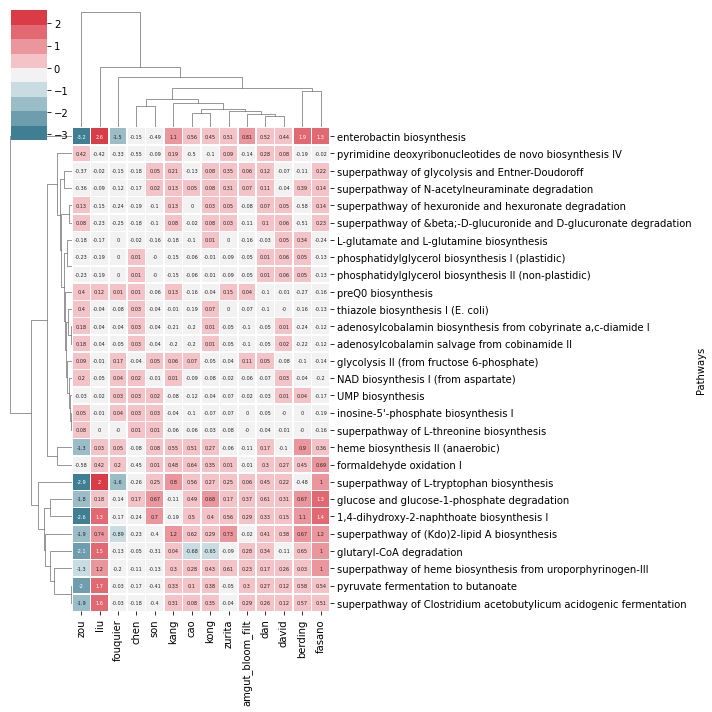

In [575]:
# Generate clustermap and export it for 
fig = plt.figure()
ax = sns.clustermap(df_idk, cmap=pallet, annot=True, annot_kws={"size": 5}, linewidth=0.5)
#ax.set_title('Significant Pathways').set_fontsize('18')
plt.savefig('../../PDFS/Pathways_sig_heatmap.pdf', bbox_inches='tight', dpi=600)
plt.show()

### Generate file to plot Extended Data FIgure 4d

In [386]:
studies = ["v3v4", "v4","aggregate","amgut_bloom_filt", "berding", "cao", "chen", "dan", "david", "huang", "fouquier", 
           "kang", "kong", "liu", "son", "zou", "zurita"]

dataframes = []

for s in studies:

    dataframes = dataframes + [picrust_analysis(s, pval=True)]

$v3v4
$v4
$aggregate
$amgut_bloom_filt
$berding
$cao
$chen
$dan
$david
$huang
$fouquier
$kang
$kong
$liu
$son
$zou
$zurita


In [387]:
Pathways = pd.concat(dataframes, axis=1, sort=False)

In [388]:
pvalstudies=[]
for i in studies:
    a = i + '_pvalue'
    pvalstudies.append(a)

In [389]:
Pathways['Pathways'] = Pathways.index
FC_melt = pd.melt(frame=Pathways, id_vars='Pathways',value_vars=studies)
FC_melt.rename(columns={'variable':'Cohort','value':'Log2(ASD/Control)'},inplace=True)

In [390]:
pval_melt = pd.melt(frame=Pathways, id_vars='Pathways',value_vars=pvalstudies)
pval_melt.rename(columns={'variable':'Cohort_p','value':'p_value'},inplace=True)
pval_melt['Cohort'] = pval_melt['Cohort_p'].str.split('_').str[0]

In [391]:
pval_melt['Cohort'] = pval_melt.apply (lambda row: correct_cohort(row), axis=1)
pval_melt['Cohort'].value_counts()

zou                 437
fouquier            437
kang                437
huang               437
cao                 437
dan                 437
chen                437
david               437
son                 437
kong                437
liu                 437
v3v4                437
berding             437
aggregate           437
v4                  437
zurita              437
amgut_bloom_filt    437
Name: Cohort, dtype: int64

In [392]:
new_df = pd.merge(FC_melt, pval_melt,  how='left', left_on=['Pathways','Cohort'], right_on = ['Pathways','Cohort'])
new_df['Significant'] = new_df['p_value'].apply(refactor_sig)

In [393]:
Pathways_quinol = new_df[new_df["Pathways"].str.contains("quinol")]
Pathways_quinol = Pathways_quinol.set_index("Pathways")

#### Export File to plot Extended Data FIgure 4d

In [382]:
Pathways_quinol.to_csv("Pathways_quinol_for_bubble_map.txt", sep='\t')

### Generate file to plot Extended Data FIgure 4e

- Chorismate related pathways

In [394]:
# Create list of downstream chorismate metabolites
searchfor = ['tryptophan', 'tyrosine', 'phenylalanine', 'indole', 'glutamate', 'chorismate', 
             'enterobactin biosynthesis', 'tetrahydrofolate', 'adenosylcobalamin']

In [395]:
new_df = new_df.set_index("Pathways")

In [396]:
# Create dataframe contianing all downstream chorismate metabolites
chorismate_all = new_df[new_df.index.str.contains('|'.join(searchfor))]
chorismate_all["Pathways"] = chorismate_all.index

,Cohort,Log2(ASD/Control),Cohort_p,p_value,Significant
Pathways,,,,,
N10-formyl-tetrahydrofolate biosynthesis,v3v4,0.023226,v3v4_pvalue,0.136373,p > 0.05
superpathway of chorismate metabolism,v3v4,-0.497068,v3v4_pvalue,0.080809,p > 0.05
chorismate biosynthesis I,v3v4,0.025695,v3v4_pvalue,0.275180,p > 0.05
adenosylcobalamin salvage from cobinamide I,v3v4,0.039069,v3v4_pvalue,0.193698,p > 0.05
enterobactin biosynthesis,v3v4,-0.559455,v3v4_pvalue,0.073392,p > 0.05
...,...,...,...,...,...
superpathway of L-phenylalanine biosynthesis,zurita,0.154418,zurita_pvalue,0.403642,p > 0.05
superpathway of L-tryptophan biosynthesis,zurita,0.252836,zurita_pvalue,0.640850,p > 0.05
superpathway of L-tyrosine biosynthesis,zurita,0.152087,zurita_pvalue,0.408376,p > 0.05


In [47]:
pathways_to_drop = ['chorismate_pathways_for_bubble_plot_2','chorismate biosynthesis II (archaea)', 'L-tryptophan degradation IX',
                   'L-tryptophan degradation XII (Geobacillus)', 'tetrapyrrole biosynthesis I (from glutamate)', 'superpathay of heme biosynthesis from glutamate',
                   'L-tryptophan degradation to 2-amino-3-carboxymuconate semialdehyde']

In [48]:
chorismate_final_pathways = chorismate_all[~chorismate_all.Pathways.isin(pathways_to_drop)]

,Cohort,Log2(ASD/Control),Cohort_p,p_value,Significant,Pathways,Pathway_group
Pathways,,,,,,,
N10-formyl-tetrahydrofolate biosynthesis,v3v4,0.023226,v3v4_pvalue,0.136373,p > 0.05,N10-formyl-tetrahydrofolate biosynthesis,tetrahydrofolate
superpathway of chorismate metabolism,v3v4,-0.497068,v3v4_pvalue,0.080809,p > 0.05,superpathway of chorismate metabolism,Chorismate
chorismate biosynthesis I,v3v4,0.025695,v3v4_pvalue,0.275180,p > 0.05,chorismate biosynthesis I,Chorismate
adenosylcobalamin salvage from cobinamide I,v3v4,0.039069,v3v4_pvalue,0.193698,p > 0.05,adenosylcobalamin salvage from cobinamide I,Vitamin B12
enterobactin biosynthesis,v3v4,-0.559455,v3v4_pvalue,0.073392,p > 0.05,enterobactin biosynthesis,Enterobactin
...,...,...,...,...,...,...,...
superpathway of L-phenylalanine biosynthesis,zurita,0.154418,zurita_pvalue,0.403642,p > 0.05,superpathway of L-phenylalanine biosynthesis,AAA
superpathway of L-tryptophan biosynthesis,zurita,0.252836,zurita_pvalue,0.640850,p > 0.05,superpathway of L-tryptophan biosynthesis,AAA
superpathway of L-tyrosine biosynthesis,zurita,0.152087,zurita_pvalue,0.408376,p > 0.05,superpathway of L-tyrosine biosynthesis,AAA


#### Export file to plot Extended Data FIgure 4e

In [50]:
chorismate_final_pathways.to_csv("chorismate_all_pathways_df_2.txt", sep='\t')

#### China vs USA Picrust analysis

In [25]:
studies = ["USA", "China"]

dataframes = []

for s in studies:

    dataframes = dataframes + [picrust_analysis(s, pval=True)]

In [26]:
Pathways = pd.concat(dataframes, axis=1, sort=False)

In [27]:
Pathways['Pathways'] = Pathways.index
FC_melt = pd.melt(frame=Pathways, id_vars='Pathways',value_vars=studies)
FC_melt.rename(columns={'variable':'Cohort','value':'Log2(ASD/Control)'},inplace=True)

In [28]:
pval_melt = pd.melt(frame=Pathways, id_vars='Pathways',value_vars=pvalstudies)
pval_melt.rename(columns={'variable':'Cohort_p','value':'p_value'},inplace=True)
pval_melt['Cohort'] = pval_melt['Cohort_p'].str.split('_').str[0]

In [29]:
pval_melt['Cohort'] = pval_melt.apply (lambda row: correct_cohort(row), axis=1)
pval_melt['Cohort'].value_counts()

China    420
USA      420
Name: Cohort, dtype: int64

In [34]:
new_df = pd.merge(FC_melt, pval_melt,  how='left', left_on=['Pathways','Cohort'], right_on = ['Pathways','Cohort'])
new_df = new_df.set_index("Pathways")

In [39]:
chorismate_all_us_china = new_df[new_df.index.str.contains('|'.join(searchfor))]
chorismate_all_us_china["Pathways"] = chorismate_all_us_china.index

In [40]:
chorismate_all_us_china["Pathway_group"] = pd.np.where(chorismate_all_us_china["Pathways"].str.contains("quinol"), "Quinol",
                   pd.np.where(chorismate_all_us_china["Pathways"].str.contains("indole"), "Indole",
                   pd.np.where(chorismate_all_us_china["Pathways"].str.contains("chorismate"), "Chorismate",
                   pd.np.where(chorismate_all_us_china["Pathways"].str.contains("enterobactin"), "Enterobactin",
                   pd.np.where(chorismate_all_us_china["Pathways"].str.contains("tetrahydrofolate"), "tetrahydrofolate",
                   pd.np.where(chorismate_all_us_china["Pathways"].str.contains("adenosylcobalamin"), "Vitamin B12",
                   pd.np.where(chorismate_all_us_china["Pathways"].str.contains("tryptophan"), "AAA", 
                   pd.np.where(chorismate_all_us_china.index.str.contains("tyrosine"), "AAA",
                   pd.np.where(chorismate_all_us_china.index.str.contains("phenylalanine"), "AAA", "Unknown")))))))))

In [41]:
chorismate_all_us_china.to_csv("chorismate_all_us_china.txt", sep='\t')